In [1]:
%reset -f
import numpy as np
from functionsAll import lstmMultiSplit
import pandas as pd
from pprint import pprint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler 
from functionsAll import originalToRecurring, lstmMultiSplit, recurringToOrignal

functionsAll.py loaded successfully


In [2]:
hour = np.arange(0, 24)
weeksInYear = np.arange(0, 52)
rcHours = originalToRecurring(ogUnits=hour, period=24)
ogHours = recurringToOrignal(rcUnits=rcHours, period=24)
rcWeeks = originalToRecurring(ogUnits=weeksInYear, period=52)
ogWeeks = recurringToOrignal(rcUnits=rcWeeks, period=52)

In [3]:
hour == ogHours

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

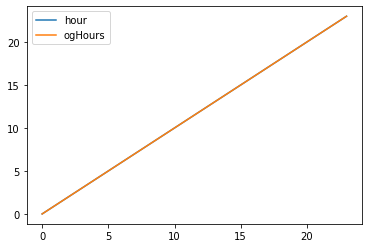

In [4]:
plt.plot(hour, label='hour')
plt.plot(ogHours, label='ogHours')
# plt.plot(rcHours, label='rcHours')
plt.legend()
plt.show()

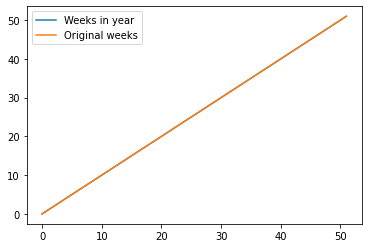

In [6]:
plt.plot(weeksInYear, label='Weeks in year')
plt.plot(ogWeeks, label='Original weeks')
# plt.plot(rcWeeks, label='Recurring weeks')
plt.legend()
plt.show()

In [4]:
df = pd.read_csv("../Data/cleanned/zusammen.csv", parse_dates=["date"])
df['dayofyear'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.week
df.drop(columns=['date','rohwert'], inplace= True)
# Conclude with 11 features, 1 label.
df = df[[ 'wert', 'day', 'month', 'dayofyear', 'year', 'weekday', 'week', 'hour','temp', 'dwpt', 'rhum', 'prcp']]
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

/home/cluster_home/yash/workspace/AutoMLRepo/Auto-ML-On-De-Pollution/autoMLVenv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [5]:
df = df.to_numpy()

In [6]:
trainX, trainY = lstmMultiSplit(df, n_past=5, n_future=1)

In [ ]:
trainX